I am experimenting with the [pupil eyetracker](https://pupil-labs.com/) and could set it up (almost) smoothly on a macOS. There is an excellent documentation, and my first goal was to just record raw data and extract eye position.

In [1]:
from IPython.display import HTML
HTML('<center><video controls autoplay loop src="https://laurentperrinet.github.io/sciblog/files/2017-12-13_pupil%20test_480.mp4" width=61.8%/></center>')

This video shows the world view (cranio-centric, from a head-mounted camera fixed on the frame) with overlaid the position of the (right) eye while I am configuring a text box. You see the eye fixating on the screen then jumping somewhere else on the screen (saccades) or on the keyboard / hands. Note that the screen itself shows the world view, such that this generates an self-reccurrent pattern.

For this, I could use the capture script and I will demonstrate here how to extract the raw data in a few lines of python code.

<!-- TEASER_END -->

In particular, we will use existing examples and rely on the [documentation](https://docs.pupil-labs.com/#pupil-data-format) of the pupil's data format.
Let's first access the data:

In [2]:
import os
home = os.environ['HOME']

In [3]:
path = os.path.join(home, 'science/pupil/pupil/recordings/2017_12_13/003')

In [4]:
!ls {path}

depth.mp4            eye0_timestamps.npy  user_info.csv
depth_timestamps.npy info.csv             world.intrinsics
exports              offline_data         world.mp4
eye0.mp4             pupil_data           world_timestamps.npy


We can have a look at the meta-data:

In [5]:
import pandas as pd
df = pd.read_csv(os.path.join(path, 'info.csv'))
df

key                                              value
0            Recording Name                                         2017_12_13
1                Start Date                                         13.12.2017
2                Start Time                                           11:33:13
3             Duration Time                                           00:00:47
4       World Camera Frames                                               2048
5   World Camera Resolution                                            640x480
6  Capture Software Version                                              1.2.7
7       Data Format Version                                              1.2.7
8               System Info  User: laurentperrinet, Platform: Darwin, Machi...

Great. Raw data is stored in the ``pupil_data`` file. To access it, we will use the following code:

In [6]:
import msgpack

msgpack is a good replacement for pickle, check out:

In [7]:
with open(os.path.join(path, 'pupil_data'), 'rb') as fh:
    pupil_data = msgpack.unpack(fh, encoding='utf-8')

There is certainly a way to use directly

``
from file_methods import load_object
l = load_object(os.path.join(path, 'pupil_data'))
``

In the meanwhile, we have all of our data:

In [8]:
pupil_data.keys()

dict_keys(['pupil_positions', 'gaze_positions', 'notifications', 'fixations'])

In [9]:
print('number of recording points: ', len(pupil_data['gaze_positions']))

number of recording points:  4943


Let's scrutinize one gaze position:

In [10]:
one_gp = pupil_data['gaze_positions'][0]
one_gp

{'base_data': [{'circle_3d': {'center': [-3.2808202989993225,
     -2.8132283347674063,
     24.500154048470392],
    'normal': [-0.6232148623038679, -0.42114559533789575, -0.6589686054214271],
    'radius': 1.5346360585292778},
   'confidence': 1.0,
   'diameter': 77.76965434697944,
   'diameter_3d': 3.0692721170585555,
   'ellipse': {'angle': 34.685331501923365,
    'axes': [41.029194035818, 77.76965434697944],
    'center': [237.79220473012253, 169.32675966117165]},
   'id': 0,
   'method': '3d c++',
   'model_birth_timestamp': 700523.227845,
   'model_confidence': 0.6947833179596574,
   'model_id': 1,
   'norm_pos': [0.37155031989081644, 0.647235917372559],
   'phi': -2.3283166698509525,
   'projected_sphere': {'angle': 90.0,
    'axes': [459.14904487414054, 459.14904487414054],
    'center': [400.30819161037704, 282.86383630445124]},
   'sphere': {'center': [4.197758048647093,
     2.2405188092873427,
     32.40777731352752],
    'radius': 12.0},
   'theta': 1.1360883069651921,
  

One may thus quickly extract data points as:

In [11]:
import numpy as np
gaze_data = np.array([(one_gp['timestamp'], one_gp['norm_pos'][0], one_gp['norm_pos'][1], one_gp['confidence']) for one_gp in pupil_data['gaze_positions']])
gaze_data[:, 0] -= gaze_data[:, 0].min()

To finish, let's plot that data as a function of time (with an evaluation of its confidence):

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

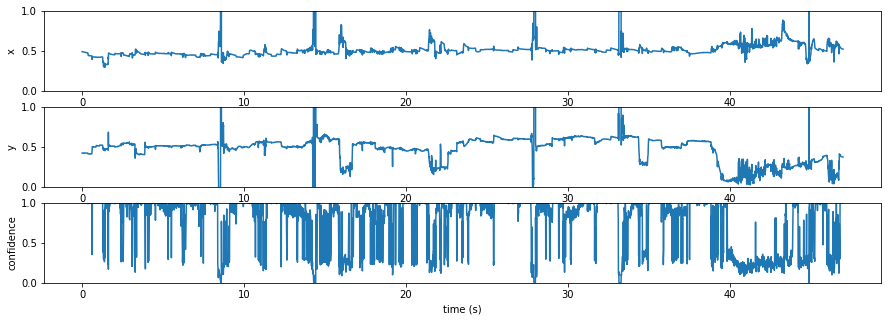

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(15, 5))
for i in range(3): 
    axs[i].plot(gaze_data[:, 0], gaze_data[:, i+1])
    axs[i].set_ylim(0, 1)
    
axs[0].set_ylabel('x')
axs[1].set_ylabel('y')
axs[2].set_ylabel('confidence')
axs[2].set_xlabel('time (s)');

... or in space:

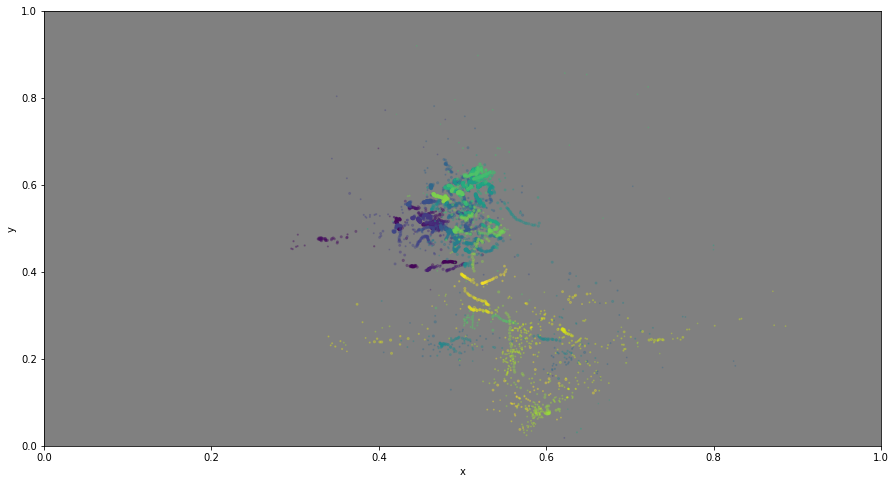

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8), subplot_kw=dict(facecolor='gray'))
ax.scatter(gaze_data[:, 1], gaze_data[:, 2], c=gaze_data[:, 0], s=gaze_data[:, -1]*5, alpha=.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xlabel('x')
ax.set_ylabel('y');

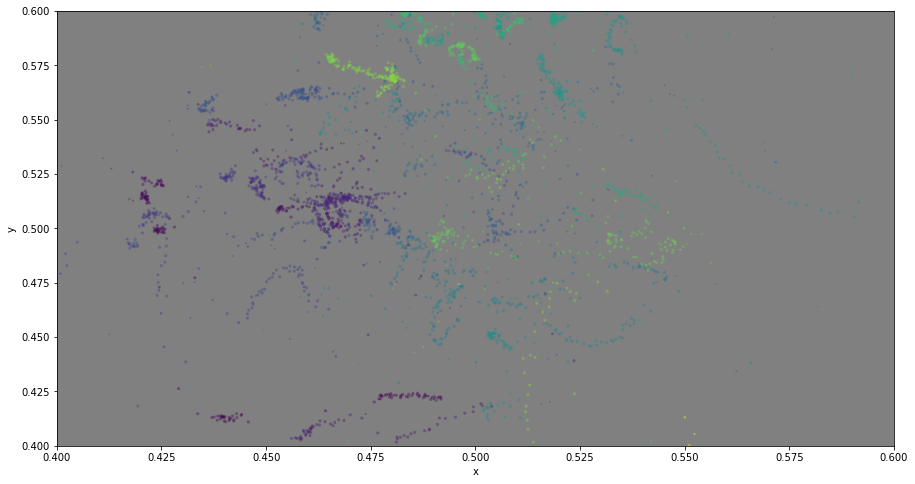

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8), subplot_kw=dict(facecolor='gray'))
ax.scatter(gaze_data[:, 1], gaze_data[:, 2], c=gaze_data[:, 0], s=gaze_data[:, -1]*5, alpha=.3)
ax.set_xlim(.4, .6)
ax.set_ylim(.4, .6)

ax.set_xlabel('x')
ax.set_ylabel('y');